In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns


np.random.seed(55)

In [3]:
#importing all the data
df_original = pd.read_csv("Data/train.csv",
                      parse_dates=["date"])
store_info = pd.read_csv("Data/stores.csv")
oil_info = pd.read_csv("Data/oil.csv",
                      parse_dates=["date"])
df_test = pd.read_csv("Data/test.csv",
                     parse_dates=["date"])
sale_count = pd.read_csv("Data/transactions.csv",
                        parse_dates=['date'])




### Combine dataframes

In [4]:
df_tmp = pd.merge(df_original, store_info)
df_tmp = pd.merge(df_tmp, oil_info)
df_tmp = pd.merge(df_tmp, sale_count)
df_test = pd.merge(df_test, store_info)
df_test = pd.merge(df_test, oil_info)
df_test = pd.merge(df_test, sale_count)

Prelim EDA

In [50]:
df_tmp.head(25)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,saleYear
0,561,1,25,1,0.000,0,21,14,4,1,52.66,770,2013
32,593,1,25,33,0.000,0,21,14,4,1,52.66,770,2013
31,592,1,25,32,0.000,0,21,14,4,1,52.66,770,2013
30,591,1,25,31,0.000,0,21,14,4,1,52.66,770,2013
29,590,1,25,30,37.847,0,21,14,4,1,52.66,770,2013
28,589,1,25,29,42.637,0,21,14,4,1,52.66,770,2013
27,588,1,25,28,0.000,0,21,14,4,1,52.66,770,2013
25,586,1,25,26,25.000,0,21,14,4,1,52.66,770,2013
24,585,1,25,25,110.801,0,21,14,4,1,52.66,770,2013
23,584,1,25,24,0.000,0,21,14,4,1,52.66,770,2013


In [6]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968483 entries, 0 to 1968482
Data columns (total 12 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 195.2+ MB


In [7]:
df_tmp.isna().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
type                0
cluster             0
dcoilwtico      59499
transactions        0
dtype: int64

### Pre-Process Data

In [8]:
#sort by date
df_tmp.sort_values(by=["date"], inplace=True, ascending=True)

In [9]:
#split date data to enrich data set + remove date column
df_tmp["saleYear"] = df_tmp.date.dt.year
# df_tmp["saleMonth"] = df_tmp.date.dt.month
# df_tmp["saleDay"] = df_tmp.date.dt.day
# df_tmp["saleDayOfWeek"] = df_tmp.date.dt.dayofweek
# df_tmp["saleDayOfYear"] = df_tmp.date.dt.dayofyear

# df_tmp.drop("date", axis=1, inplace=True)

df_test["saleYear"] = df_test.date.dt.year
# df_test["saleMonth"] = df_test.date.dt.month
# df_test["saleDay"] = df_test.date.dt.day
# df_test["saleDayOfWeek"] = df_test.date.dt.dayofweek
# df_test["saleDayOfYear"] = df_test.date.dt.dayofyear

# df_test.drop("date", axis=1, inplace=True)

In [10]:
#fill missing data in both sets
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #fill with median
            df_tmp[label] = content.fillna(content.median())
            
for label, content in df_test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #fill with median
            df_test[label] = content.fillna(content.median())

In [12]:
#turn cat vars into num
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        #into num and +1
        df_tmp[label] = pd.Categorical(content).codes+1

for label, content in df_test.items():
    if not pd.api.types.is_numeric_dtype(content):
        #into num and +1
        df_test[label] = pd.Categorical(content).codes+1

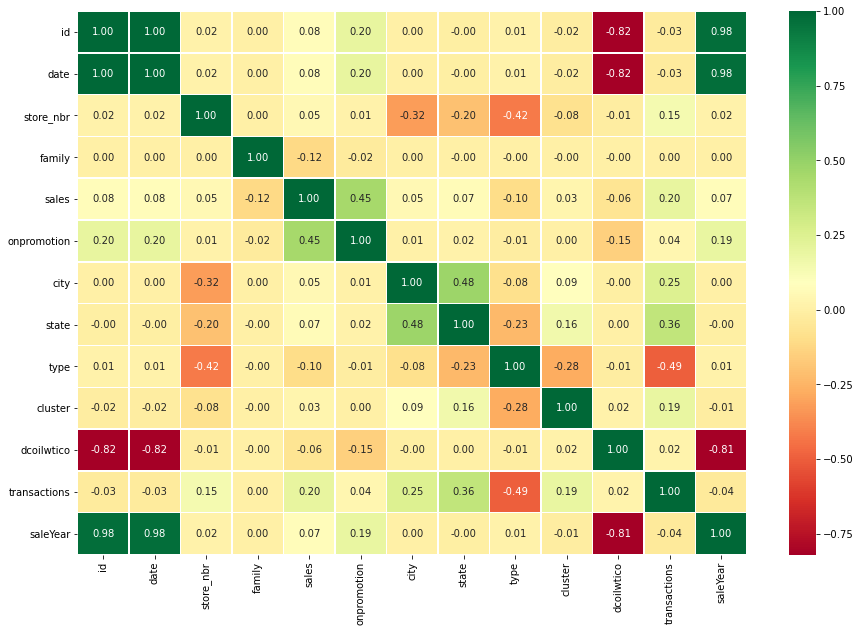

In [13]:
#correlation matrix
corr_matrix = df_tmp.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="RdYlGn");

## Modeling

In [47]:
#since sklearn is out of date, create rmsle score, and add other metrics
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

In [15]:
df_val = df_tmp[df_tmp.saleYear >= 2016]
df_train = df_tmp[df_tmp.saleYear < 2016]

X_train, y_train = df_train.drop("sales", axis=1), df_train.sales
X_valid, y_valid = df_val.drop("sales", axis=1), df_val.sales

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1233408, 12), (1233408,), (735075, 12), (735075,))

In [38]:
# # max samples in random forest
# model = RandomForestRegressor(n_jobs=-1,
#                              random_state=1,
#                              max_samples=200000)
# model.fit(X_train,y_train)

In [39]:
#boost model
model = GradientBoostingRegressor()

model.fit(X_train, y_train)

GradientBoostingRegressor()

In [40]:
model.score(X_valid, y_valid)

0.7280299652002151

In [48]:
show_scores(model)

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [32]:
#from sklearn.model_selection import RandomizedSearchCV

#different RFR hypers
rf_grid = {"n_estimators": np.arange(10, 180, 10),
          "max_depth": [None, 3, 5, 10, 15],
          "min_samples_split": np.arange(2, 24, 2),
          "min_samples_leaf": np.arange(1, 24, 2),
          "max_features": [0.5, 1, "sqrt", "auto", "log2"],
          "max_samples": [200000]}
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=1),
                              param_distributions=rf_grid,
                              n_iter=10,
                              cv=5,
                              verbose=True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
                   param_distributions={'max_depth': [None, 3, 5, 10, 15],
                                        'max_features': [0.5, 1, 'sqrt', 'auto',
                                                         'log2'],
                                        'max_samples': [200000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170])},
                   verbose=True)

In [33]:
rs_model.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 23,
 'max_samples': 200000,
 'max_features': 'auto',
 'max_depth': None}

In [36]:
tuned_model = RandomForestRegressor(n_jobs=-1,
                             random_state=1,
                             #max_samples=200000,
                                    n_estimators=100,
                                   min_samples_split=2,
                                   min_samples_leaf=23,
                                   max_features='auto')
                                   #max_depth=5)
tuned_model.fit(X_train,y_train)

RandomForestRegressor(min_samples_leaf=23, n_jobs=-1, random_state=1)

In [37]:
show_scores(tuned_model)

{'Training RMSLE': 0.4106705729773168,
 'Valid RMSLE': 0.7706195756178232,
 'Training R^2': 0.948443112147028,
 'Valid R^2': 0.825086711637955}